<a href="https://colab.research.google.com/github/Ritukuklani/Deep-Learning/blob/main/hw1prob4_neuralnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OK, thus far we have been talking about linear models. All these can be viewed as a single-layer neural net. The next step is to move on to multi-layer nets. Training these is a bit more involved, and implementing from scratch requires time and effort. Instead, we just use well-established libraries. I prefer PyTorch, which is based on an earlier library called Torch (designed for training neural nets via backprop).

In [ ]:
import numpy as np
import torch
import torchvision

Torch handles data types a bit differently. Everything in torch is a *tensor*.

In [ ]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

# Q4.1 Display the contents of a, b

print(a)
print(b)

[[0.97941015 0.16213134 0.30569123]
 [0.69163066 0.97256496 0.76706805]]
tensor([[0.9794, 0.1621, 0.3057],
        [0.6916, 0.9726, 0.7671]], dtype=torch.float64)


The idea in Torch is that tensors allow for easy forward (function evaluations) and backward (gradient) passes.

In [ ]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad=True)

y = torch.matmul(A,x) + b

print(y)
z = y.sum()
print(z)
z.backward()
print(x.grad)
print(x)

tensor([[1.0440],
        [0.7221]], grad_fn=<AddBackward0>)
tensor(1.7660, grad_fn=<SumBackward0>)
tensor([[0.5686],
        [0.3368]])
tensor([[0.9506],
        [0.0330]], requires_grad=True)


Notice how the backward pass computed the gradients using autograd. OK, enough background. Time to train some networks. Let us load the *Fashion MNIST* dataset, which is a database of grayscale images of clothing items.

In [ ]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let us examine the size of the dataset.

In [ ]:
# Q4.2 How many training and testing data points are there in the dataset? 
# What is the number of features in each data point?

print(len(trainingdata))
print(len(testdata))
# print(trainingdata[0].shape)
image, label = trainingdata[0]
image.numel()




60000
10000


784

Let us try to visualize some of the images. Since each data point is a tensor (not an array) we need to postprocess to use matplotlib.

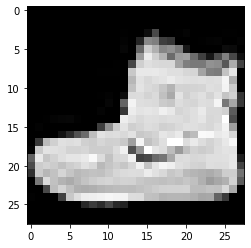

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = trainingdata[0]
# Q4.3 Assuming each sample is an image of size 28x28, show it in matplotlib.

plt.imshow(image.squeeze().numpy(),cmap=plt.cm.gray)
plt.show()


Let's try plotting several images. This is conveniently achieved in PyTorch using a *data loader*, which loads data in batches.

In [ ]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
images, labels = iter(trainDataLoader).next()
print(images.size(), labels)
print(labels.shape)

torch.Size([64, 1, 28, 28]) tensor([5, 1, 8, 1, 2, 9, 4, 9, 1, 9, 1, 0, 9, 3, 7, 3, 3, 9, 3, 8, 5, 1, 0, 5,
        0, 1, 7, 5, 4, 4, 6, 6, 4, 7, 5, 4, 0, 9, 2, 6, 9, 1, 4, 5, 5, 7, 0, 3,
        5, 0, 0, 1, 1, 5, 2, 0, 9, 7, 6, 1, 3, 9, 2, 9])
torch.Size([64])


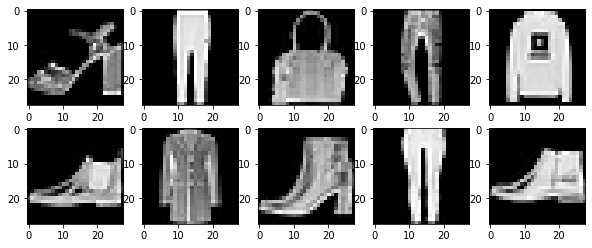

In [ ]:
# Q4.4 Visualize the first 10 images of the first minibatch 
# returned by testDataLoader.

plt.figure(figsize=(10,4))
for index in np.arange(0,10):
  plt.subplot(2,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

Now we are ready to define our linear model. Here is some boilerplate PyTorch code that implements the forward model for a single layer network for logistic regression (similar to the one discussed in class notes). 

In [ ]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)



In [ ]:
train_loss_history = []
test_loss_history = []

# Q4.5 Write down a for-loop that trains this network for 20 minibatch iterations, 
# and print the train/test losses.
# Save them in the variables above. If done correctly, you should be able to 
# execute the next code block.

for iters in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    
    optimizer.zero_grad()
    predicted_output = net(images)
    # print("p",predicted_output.shape)
    # print("l",labels.shape)
    
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Iters %s, Train loss %s, Test loss %s'%(iters, train_loss, test_loss))


Iters 0, Train loss 0.9639381256693208, Test loss 0.7399378606847896
Iters 1, Train loss 0.6685637201327504, Test loss 0.6480052791962958
Iters 2, Train loss 0.6042290101808779, Test loss 0.605348605259209
Iters 3, Train loss 0.5692943858185302, Test loss 0.5815254913014212
Iters 4, Train loss 0.5461783164155001, Test loss 0.5620633929398409
Iters 5, Train loss 0.5295387048965324, Test loss 0.5497166810521654
Iters 6, Train loss 0.5168527866413852, Test loss 0.5404487956481375
Iters 7, Train loss 0.5067626559880497, Test loss 0.5302914177915853
Iters 8, Train loss 0.4980484282792504, Test loss 0.5219245932664082
Iters 9, Train loss 0.4908070791758962, Test loss 0.5162081223004943
Iters 10, Train loss 0.4843805459643732, Test loss 0.5101567125244505
Iters 11, Train loss 0.4792964312790045, Test loss 0.5051668984874799
Iters 12, Train loss 0.4744041182243748, Test loss 0.5038991291431865
Iters 13, Train loss 0.47040176599709466, Test loss 0.4998610224693444
Iters 14, Train loss 0.4666247


Cool! Now we have set everything up. Let's try to train the network.

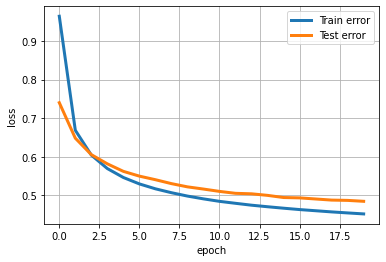

In [ ]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Neat! Now let's evaluate our model accuracy on the entire dataset. The predicted class label for a given input image can computed by looking at the output of the neural network model and computing the index corresponding to the maximum activation. Something like

*predicted_output = net(images)*
*_, predicted_labels = torch.max(predicted_output,1)*

In [ ]:
predicted_output = net(images)
print(torch.max(predicted_output, 1))
fit = Loss(predicted_output, labels)
print(labels)

torch.return_types.max(
values=tensor([ 6.1588,  2.9972,  8.8261,  7.8346,  6.7599,  6.3033,  9.9705,  4.2320,
         7.1605, 11.8063, 10.4222, 10.5626,  6.5620,  4.7938,  9.2627,  4.5134],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')


In [ ]:
def evaluate(dataloader):
  # Q4.6 Implement a function here that evaluates training and testing accuracy.
  # Here, accuracy is measured by probability of successful classification.
  total, correct = 0, 0
  net.eval() # don't update weights
  for data in dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    predicted_output = net(images)
    _, predicted_labels = torch.max(predicted_output,1)
    total += labels.size(0)
    correct += (predicted_labels == labels).sum().item()
  return 100 * correct/total

print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(trainDataLoader), evaluate(testDataLoader)))

Train acc = 84.77, test acc = 83.05
